## Heart Rate Variability Analysis

Assumes Ch0 = Breath, Ch1 = Heart <br>
This script will crash with large files (> 20 min recordings) if run in Jupyter notebooks <br>
For large files, run in the python terminal<br>
For very large files, run on the High Performace Computing core (Research Bioinformatics, contact Marc Carlson or Glenn Morton)<br>

### User Input

In [2]:
# File variables
dir_in = r'C:\Users\haley\Dropbox\Code\Heartrate Variability'
dir_out = dir_in + r'\analyzed'
file_in = 'BL6_P15_0001.abf'

start_mins = 0 # in Minutes from the ABF file (use clampfit to find window)
end_mins = 0.05 # Last data point to analyze. -9999 indicates the whole file

# Exclusion criteria
threshold1 = 0.4     # min amplitude to signal a peak on Ch0 (half peak)
threshold2 = 0.05    # min amplitdue to signal a peak on Ch1

### Add experiment Notes

* Opened the original file in Clampfit and sected a few regions of interest up to 5 min long for testing
* Analyzed data and parameters can be found in a subfolder of the input directory named "analyzed"

### Load Packages

In [3]:
import pyabf
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### Load Traces Into Python and Initialize Variables
  


In [4]:
os.chdir (dir_in)
abf = pyabf.ABF(file_in) 
smpl = abf.dataPointsPerMs # Scale factor for reading the raw data into the graph (in ms - must be integer)
start = round(start_mins * 60 * 1000/smpl)
end = round(end_mins * 60 * 1000/smpl)
start_s = round(start_mins * 60)
end_s = round(end_mins * 60 )
start_ms = round(start_mins * 60/1000)
end_ms = round(end_mins * 60/1000 )

# Assemble meta data for parameters text file
meta_name = file_in.split('.abf')
exp_name = meta_name[0]
meta_text = meta_name[0] + '_parameters.txt'
meta_date = datetime.now()
meta_date = 'Time of run =  ' + meta_date.strftime("%m/%d/%Y, %H:%M:%S")
meta_filein = 'Input file = ' + dir_in + file_in
meta_dirout = 'Output directory = ' + dir_out
meta_mins = 'Analysis window (in minutes) = ' + str(start_mins) + ' , ' + str(end_mins)
meta_s = 'Analysis window (in s) = ' + str(start_s) + ' , ' + str(end_s)
meta_dp ='Analysis window (in datapoints) = ' + str(start) + ' , ' + str(end)
meta_out = [meta_date, meta_filein, meta_dirout, meta_mins, meta_s, meta_dp]

try:
    os.stat(dir_out)
except:
    os.makedirs(dir_out)
os.chdir(dir_out)
f = open(meta_text,"w+")
for meta in meta_out:
    f.write (meta + '\n')
    print(meta)
f.close ()
os.chdir(dir_in)

Time of run =  12/13/2019, 13:14:03
Input file = C:\Users\haley\Dropbox\Code\Heartrate VariabilityBL6_P15_0001.abf
Output directory = C:\Users\haley\Dropbox\Code\Heartrate Variability\analyzed
Analysis window (in minutes) = 0 , 0.05
Analysis window (in s) = 0 , 3
Analysis window (in datapoints) = 0 , 1500


### Custom Function Definitions

In [5]:
def save_csv (df_out, file_out, dir_out):
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)

    # Write data to file
    os.chdir(dir_out)
    df_out.to_csv(file_out, index = False)
    
def save_fig (fig, file_name, dir_out):
    try:
        os.stat(dir_out)
    except:
        os.makedirs(dir_out)
    os.chdir(dir_out)
    fig.savefig (file_name, dpi= 300, facecolor='w', edgecolor='w',  
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        metadata=None)

def get_breath (abf, start, end):
    if end == -9999:
        end = len(abf.sweepY)
    
    # Get baselines for Ch1 and Ch0
    abf.setSweep (sweepNumber = 0, channel = 0) # sets current channel to Ch1
    baseline = np.mean(abf.sweepY[:]) # average of the entire trace in Ch0
    
    breaths_start = []
    breaths_end = []
    i=0 # current datapoint
    
    while i < end:
        current = abf.sweepY[i]
        if current-baseline > threshold1:
            pt1 = i # starting datapoint of peak
            j = i
            while abf.sweepY[j]-baseline > threshold1/2:
                j = j+1
                i = i + 1   
            pt2 = j # end of peak
            breaths_start.append(pt1)
            breaths_end.append(pt2)
        i = i + 1        
    return breaths_start, breaths_end
    
    
def get_heart (abf, start, end):
    if end == -9999:
        end = len(abf.sweepY)
    
    # Get baselines for Ch1 and Ch0
    abf.setSweep (sweepNumber = 0, channel = 1) # sets current channel to Ch1
    baseline = np.mean(abf.sweepY[:]) # average of the entire trace in Ch0
    heart_start = []
    heart_end = []
    i=0
    
    while i < end:
        current = abf.sweepY[i]
        if current-baseline > threshold2:
            pt3 = i
            j = i
            while abf.sweepY[j]-baseline > threshold2:
                j = j+1
                i = i + 1   
            pt4 = j
            heart_start.append(pt3)
            heart_end.append(pt4)
        i = i + 1
            
        
    return heart_start, heart_end
  
def plot_breath (abf, start, end):
    fig, ax = plt.subplots(2,1, figsize=(8, 8), dpi = 100)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    abf.setSweep (sweepNumber = 0, channel = 0)
    ax[0].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
    #ax[0].annotate('*', xy=(abf.sweepX[peak], abf.sweepY[peak]), color = 'black')
    
    abf.setSweep (sweepNumber = 0, channel = 1)
    ax[1].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
    
def plot_heart (abf, start, end):
    fig, ax = plt.subplots(2,1, figsize=(8, 8), dpi = 100)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    
    abf.setSweep (sweepNumber = 0, channel = 1)
    ax[0].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
    #ax[0].scatter (abf.sweepX[peak_x], abf.sweepY[peak_y])
    
    abf.setSweep (sweepNumber = 0, channel = 0)
    ax[1].plot (abf.sweepX[start:end], abf.sweepY[start:end], linestyle = 'solid')
       
        
def get_breath_peak (abf, breath1):
    abf.setSweep (sweepNumber = 0, channel = 0)
    breath_y = []   
    breath_x = []    # datapoints
    breath_time = [] # ms
    i = 0
    while i < len (breath1)-1:
        # Find breath peak y value
        breath_peak_y = max(abf.sweepY[breath1[i]:breath1[i+1]])
        breath_y.append(breath_peak_y)
        
        # Find breath peak x value
        for breath in range(breath1[i],breath1[i+1]):
            if abf.sweepY[breath] == breath_peak_y:
                breath_x.append(breath)
                breath_time.append(abf.sweepX[breath])
        i = i+1
    return breath_x,breath_time, breath_y

def get_heart_peaks (abf, heart1):
    abf.setSweep (sweepNumber = 0, channel = 1)
    heart_y = []   
    heart_x = []    # datapoints
    heart_time = [] # ms
    i = 0
    while i < len (heart1)-1:
        # Find breath peak y value
        heart_peak_y = max(abf.sweepY[heart1[i]:heart1[i+1]])
        heart_y.append(heart_peak_y)
        
        # Find breath peak x value
        for heart in range(heart1[i],heart1[i+1]):
            if abf.sweepY[heart] == heart_peak_y:
                heart_x.append(heart)
                heart_time.append(abf.sweepX[heart])
        i = i+1
    return heart_x,heart_time, heart_y

def get_heart_peak (abf, breath_x, breath1):
    abf.setSweep (sweepNumber = 0, channel = 1)
    heart_y = []   
    heart_x = []    # datapoints
    heart_time = [] # ms
    i = 1
    while i < len (breath1):
        # Find heart peak y value
        heart_peak_y = max(abf.sweepY[breath_x[i-1]:breath1[i]])
        heart_y.append(heart_peak_y)
        
        # Find heart peak x value
        for heart in range(breath_x[i-1],breath1[i]):
            if abf.sweepY[heart] == heart_peak_y:
                heart_x.append(heart)
                heart_time.append(abf.sweepX[heart])
        i = i+1
    return heart_x,  heart_time, heart_y

def plot_peaks (abf, breath1, threshold1, threshold2, breath_time, heart_time, breath_y, heart_y):
    # Plot Breath Epoch with Peak
    i = 0
    while i < len(breath1)-1:
   
        fig, ax = plt.subplots(2,1, figsize=(6, 8), dpi = 100)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['top'].set_visible(False)
    
        #Plot Breath Peaks
        abf.setSweep (sweepNumber = 0, channel = 0)
        x_values = abf.sweepX[breath1[i] : breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = breath_time[i]-0.005
        y_peak = breath_y[i]+ threshold1 * 0.1
        ax[0].plot (x_values, y_values , linestyle = 'solid')
        ax[0].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[0].set_ylim(min(y_values) - threshold1 * 0.5 , max(y_values) + threshold1 * 0.5)
    
        # Plot Heart Peaks
        abf.setSweep (sweepNumber = 0, channel = 1)
        x_values = abf.sweepX[breath1[i]:breath1[i+1]]
        y_values = abf.sweepY[breath1[i]:breath1[i+1]]
        x_peak = heart_time[i]-0.005
        y_peak = heart_y[i]+ threshold2 *0.1
        ax[1].plot (x_values, y_values , linestyle = 'solid')
        ax[1].annotate('*', xy=(x_peak, y_peak), size = 25, color = 'black') 
        ax[1].set_ylim(min(y_values) - threshold2 * 0.5 , max(y_values) + threshold2 * 0.5)
    
        # 0.005 adjustment (1 dp = 0.005 seconds) 
        # Takes into account that the plot starts at data point #1, but arrays in python start at #0
        # Without the adjustment, the asterisk would be shifted one datapoint ahead of the actual peak (+ 0.005s)
        # Y axis is also adjusted on peak annotation by shifting up 10% to avoid obscuring the actual data
        # Y axis limits are set to 50% of threshold above max and min Y values
        
        i = i + 1

### Get all breath peaks

In [6]:
# Get Breath Epoch
breath1, breath2 = get_breath (abf, start, end) 

# Get Breath Peaks
breath_x, breath_ms, breath_y = get_breath_peak (abf, breath1)

df_breaths = pd.DataFrame()
df_breaths['breath_peaks_x'] = breath_x
df_breaths['breath_peaks_ms'] = breath_ms
df_breaths['breath_peaks_y'] = breath_y
display(HTML(df_breaths.to_html()))

save_csv(df_breaths, exp_name + '_all_breaths.csv', dir_out)


,breath_peaks_x,breath_peaks_ms,breath_peaks_y
0,57,0.0285,0.668030
1,574,0.2870,0.707092


### Calculate Firing rate of breaths

In [7]:
spike_num = len(df_breaths.breath_peaks_x)
epoch_length = end_s - start_s
spike_rate = spike_num/epoch_length

# Add to the parameters text file
os.chdir(dir_out)
f = open(meta_text,"a")
f.write ('Breath spikes = ' + str(spike_num) +  '\n')
f.write ('Timeframe = ' + str(epoch_length) +  '\n')
f.write ('Breath rate = ' + str(spike_rate) +  '\n')
print('Breath spikes = ', spike_num)
print('Epoch Length = ', epoch_length)
print('Breath rate = ', spike_rate)
f.close ()
os.chdir(dir_in)

Breath spikes =  2
Epoch Length =  3
Breath rate =  0.6666666666666666


### Get all heart peaks

In [8]:
heart1, heart2 = get_heart (abf, start, end)

# Get Heart Peaks
heart_x, heart_ms, heart_y = get_heart_peaks (abf, heart1)

df_heart = pd.DataFrame()
df_heart['breath_peaks_x'] = heart_x
df_heart['breath_peaks_ms'] = heart_ms
df_heart['breath_peaks_y'] = heart_y
display(HTML(df_heart.to_html()))

save_csv(df_heart, exp_name + '_all_hearts.csv', dir_out)

,breath_peaks_x,breath_peaks_ms,breath_peaks_y
0,9,0.0045,0.076599
1,191,0.0955,0.069885
2,372,0.1860,0.067139
3,559,0.2795,0.067444
4,740,0.3700,0.074158
5,931,0.4655,0.061035
6,1121,0.5605,0.066833
7,1299,0.6495,0.062256


### Get Heart Peak Following a Breath Peak

,breath_peaks_x,breath_peaks_ms,breath_peaks_y,heart_peaks_x,heart_peaks_ms,heart_peaks_y
0,57,0.0285,0.668030,191,0.0955,0.069885
1,574,0.2870,0.707092,740,0.3700,0.074158


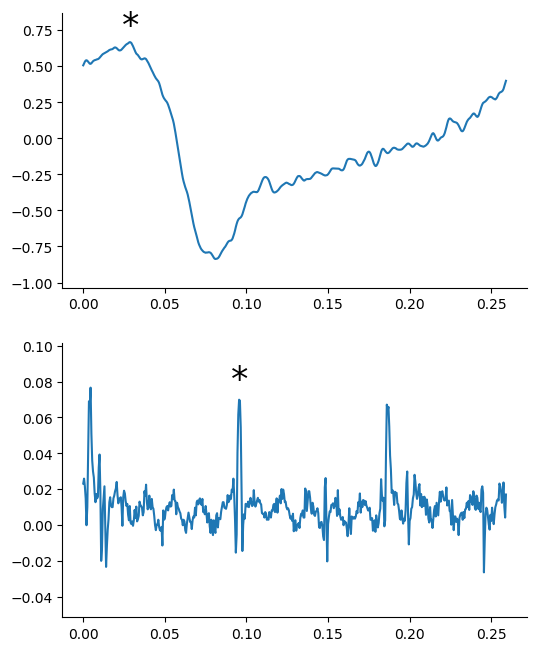

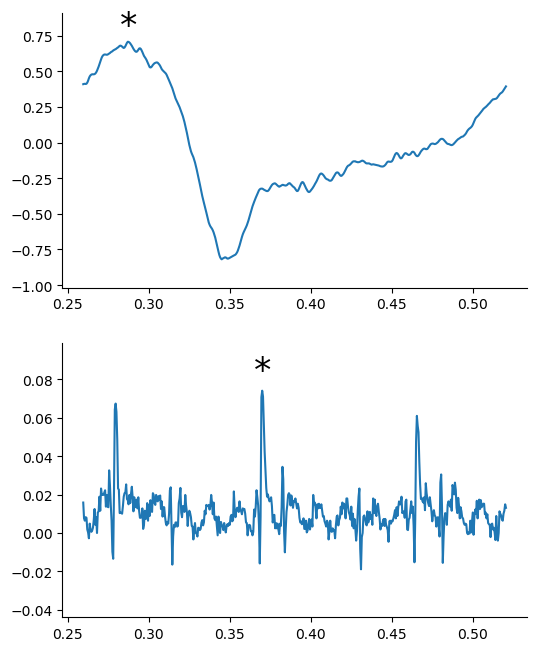

In [9]:
# Get Breath Epochs
breath1, breath2 = get_breath (abf, start, end) 

# Get Breath Peaks
breath_x, breath_ms, breath_y = get_breath_peak (abf, breath1)

# Get Heart Peak
heart_x, heart_ms, heart_y = get_heart_peak (abf, breath_x, breath1)

# Plot heart peak relative to breath peak
plot_peaks (abf, breath1, threshold1, threshold2, breath_ms, heart_ms, breath_y, heart_y)

# Table output of all calculated data
df_breath_heart = pd.DataFrame()
df_breath_heart['breath_peaks_x'] = breath_x
df_breath_heart['breath_peaks_ms'] = breath_ms
df_breath_heart['breath_peaks_y'] = breath_y
df_breath_heart['heart_peaks_x'] = heart_x
df_breath_heart['heart_peaks_ms'] = heart_ms
df_breath_heart['heart_peaks_y'] = heart_y
display(HTML(df_breath_heart.to_html()))

# Save data to a csv (Comma Separated Values) Spreadsheet that can be opened in Excel
save_csv(df_breath_heart, exp_name + '_breath_heart.csv', dir_out)

### Calculate Latency between breath spike and heart spike

In [11]:
df_latency = df_breath_heart.copy() # Always work with a copy of the original dataframe to prevent overwriting data

latencies_dp = []
latencies_ms = []

i = 0
while i < len(df_latency.breath_peaks_x):
    latency_dp = df_latency.heart_peaks_x[i] - df_latency.breath_peaks_x[i]
    latency_ms = df_latency.heart_peaks_ms[i] - df_latency.breath_peaks_ms[i]
    latencies_dp.append(latency_dp)
    latencies_ms.append(latency_ms)
    i = i + 1
        
# Add latencies to the csv file
df_breath_heart['latency_dp'] = latencies_dp
df_breath_heart['latency_ms'] = latencies_ms
save_csv(df_breath_heart, exp_name + '_breath_heart.csv', dir_out)
display(HTML(df_breath_heart.to_html()))



,breath_peaks_x,breath_peaks_ms,breath_peaks_y,heart_peaks_x,heart_peaks_ms,heart_peaks_y,latency_dp,latency_ms
0,57,0.0285,0.668030,191,0.0955,0.069885,134,0.067
1,574,0.2870,0.707092,740,0.3700,0.074158,166,0.083
